In this notebook, performance of the best classification model on the test set is evaluated on cleaned dataset of different years. Furthermore, SHAP analysis is used to model interpretation.

In [1]:
##defining the path to the pre-processed datasets.

from google.colab import drive
drive.mount('/content/gdrive')
data_path = '/content/gdrive/Shareddrives/CIS520 Final Project/dataset/pre_processed/'

Mounted at /content/gdrive


In [2]:
##Importing the required libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
import lightgbm as lgb
from google.colab import files
!pip3 install shap
import shap

     |████████████████████████████████| 564 kB 8.7 MB/s 


In [3]:
##Reading the cleaned datasets for 2011-2015
df_2011 = pd.read_csv(data_path + '2011_selected.csv')
df_2012 = pd.read_csv(data_path + '2012_selected.csv')
df_2013 = pd.read_csv(data_path + '2013_selected.csv')
df_2014 = pd.read_csv(data_path + '2014_selected.csv')
df_2015 = pd.read_csv(data_path + '2015_selected.csv')

## Performance of the Selected Model on the cleaned datasets of different years

Since the training and testing for models was done on only the cleaned 2015 dataset, we were interested in seeing how the selected model performs on the datasets from other years. In this notebook, we test the predictive capabilities of the selected LightGBM model (based on the performance on test set) on the cleaned datasets of years 2011-14. 

In [5]:
## Function to evaluate the performance of the selected LightGBM model on the cleabed dataset of a year
def eval_model_performance(model,year,df,threshold):
    """
    Parameters
    ----------
    model : Trained binary classiification model 
        Selected LightGBM classifier
    year : str
        year for which evaluation metrics has to be calculated
    df : pandas dataframe
        cleaned dataset 
    threshold: Float
        Classification threshold to be used for class prediction
    """

    ##Defining the X (feature values) and y (test variable) 
    X = df.drop(['Unnamed: 0','DIABETE3','_TOTINDA'], axis = 1).values
    y = df['DIABETE3'].values.astype('int64')

    ##probabilities for the two classes from the model
    yhat = model.predict_proba(X)
    ##keeping the probabilities for the positive (which is diabetic in our case) outcome only
    yhat = yhat[:, 1]

    ##Predict the classes based on the threshold, i.e. if probability >= threshold, then class is 1 (diabetic)
    y_pred = np.zeros(yhat.shape)
    y_pred[np.where(yhat>=threshold)] = 1

    print('Scores for %s:' % year)
    ##Compute precision for the cleaned dataset for given year
    print('Precision: %.3f' % precision_score(y,y_pred))
    ##Compute recall for the cleaned dataset for given year
    print('Recall: %.3f' % recall_score(y,y_pred))
    ##Compute F1-score for the cleaned dataset for given year
    print('F1-score: %.3f' % f1_score(y,y_pred))

We have the hyperparameter values and the classification threshold for the selected LighGBM model from the Ensemble_Methods.ipynb notebook.

In [6]:
##Reading the Train set 
train = pd.read_csv(data_path + 'Train.csv')
##Defining the X (feature values) and y (target variable) for training
X_train = train.drop(['DIABETE3','_TOTINDA'], axis = 1).values
y_train = train['DIABETE3'].values.astype('int64')

##hyperparameters for the selected LightGBM model
lgbmc_best_hp={'colsample_bytree': 0.8002875270990324, 'learning_rate': 0.0599624618392627, 'max_depth': 3, 'min_split_gain': 0.24613935939490317, 'n_estimators': 491, 'reg_lambda': 3.202973397807609, 'scale_pos_weight': 3.8529686221558865, 'subsample': 0.5283968376023029}
##define LightGBM classifier 
lgbmc_best = lgb.LGBMClassifier(objective='binary',random_state=1,**lgbmc_best_hp)

##Fitting the selected LightGBM classifier on training set
lgbmc_best.fit(X_train,y_train)

##Defining the threshold for classification
threshold_lgbm = 0.547586

df_years = {"2011": df_2011,"2012": df_2012,"2013": df_2013,"2014": df_2014,"2015": df_2015}
##performance of the selected LightGBM model on different years
for key,value in df_years.items():
    eval_model_performance(lgbmc_best,key,value,threshold_lgbm)
    print()

Scores for 2011:
Precision: 0.374
Recall: 0.608
F1-score: 0.463

Scores for 2012:
Precision: 0.375
Recall: 0.611
F1-score: 0.465

Scores for 2013:
Precision: 0.380
Recall: 0.618
F1-score: 0.471

Scores for 2014:
Precision: 0.383
Recall: 0.622
F1-score: 0.474

Scores for 2015:
Precision: 0.391
Recall: 0.633
F1-score: 0.483



## Model Interpretation using SHAP

We use SHAP analysis on the selected LightGBM model to determine the impact of different features in model prediction for different cleaned datasets (2011-2014).

In [7]:
##Defining list of feature names
feature_names = df_2015.columns.drop(['Unnamed: 0','DIABETE3','_TOTINDA'])

##Defining the SHAP explainer which in this case is TreeExplainer
explainer = shap.TreeExplainer(lgbmc_best)
##Finding the SHAP values
shap_values_2011 = explainer.shap_values(df_2011.drop(['Unnamed: 0','DIABETE3','_TOTINDA'], axis = 1))
shap_values_2012 = explainer.shap_values(df_2012.drop(['Unnamed: 0','DIABETE3','_TOTINDA'], axis = 1))
shap_values_2013 = explainer.shap_values(df_2013.drop(['Unnamed: 0','DIABETE3','_TOTINDA'], axis = 1))
shap_values_2014 = explainer.shap_values(df_2014.drop(['Unnamed: 0','DIABETE3','_TOTINDA'], axis = 1))
shap_values_2015 = explainer.shap_values(df_2015.drop(['Unnamed: 0','DIABETE3','_TOTINDA'], axis = 1))

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


First looking at the SHAP plots for cleaed 2015 dataset.

SHAP summary plots for 2015:


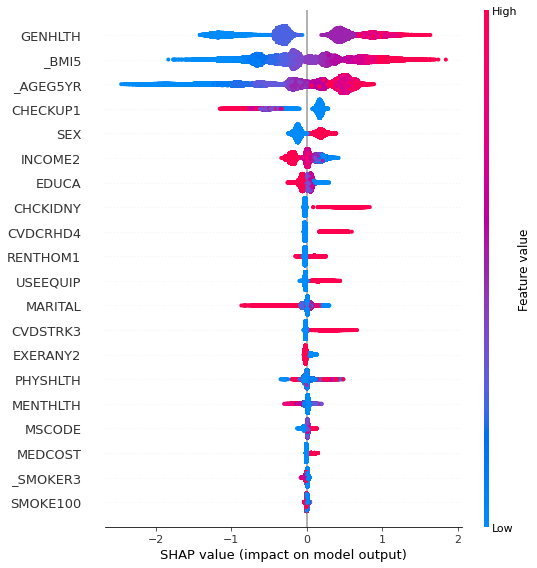

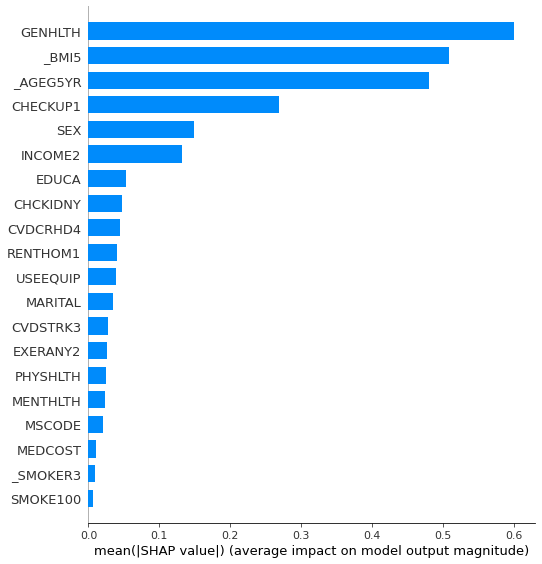

In [9]:
print("SHAP summary plots for 2015:")
shap.summary_plot(shap_values_2015[1], df_2015.drop(['Unnamed: 0','DIABETE3','_TOTINDA'], axis = 1))
shap.summary_plot(shap_values_2015[1], feature_names, plot_type='bar',)

The SHAP summary plot in shows that the 6 most features for cleaned 2015 dataset in decreasing order are GENHLTH, \_BMI5, \_AGE5YR, CHECKUP, SEX and INCOME2. The mean($|\text{SHAP value}|$) for these features are in the range 0.14 - 0.6, on the other hand the mean value for each of the remaining 16 features is $\leq0.05$. This indicates that the combined impact of top 6 features on the model output is much higher than the total impact of the remaining 16 features.

Next we see the SHAP plots for other four years 2011-2015

SHAP summary plots for 2011:


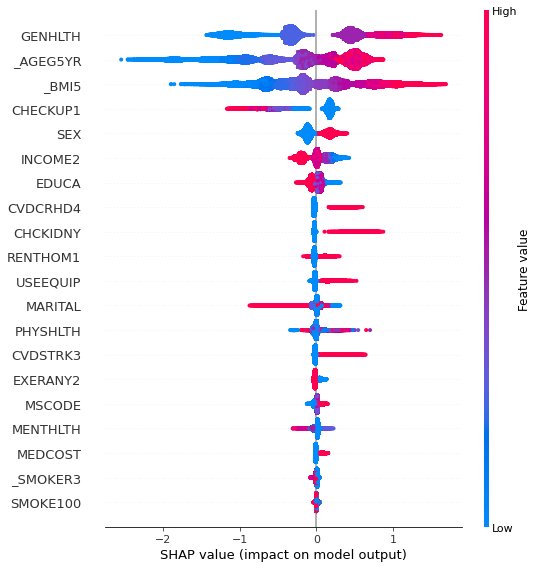

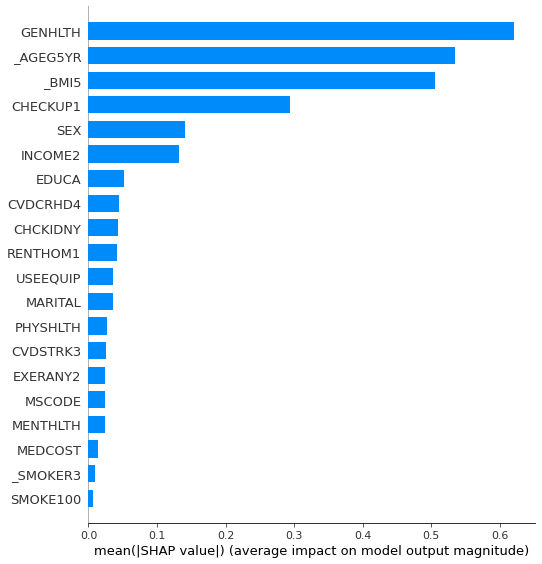


SHAP summary plots for 2012:


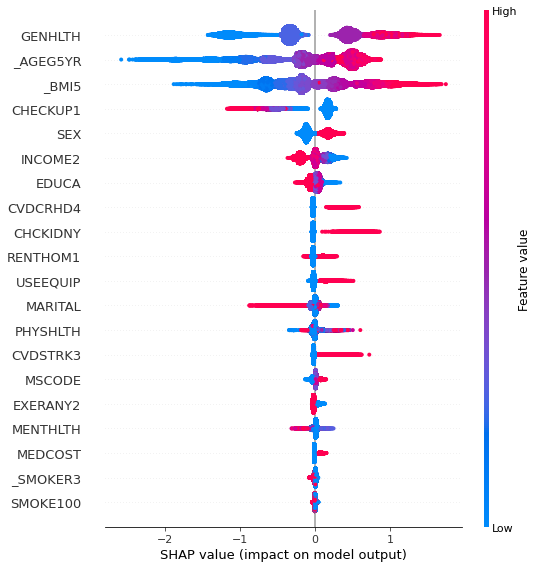

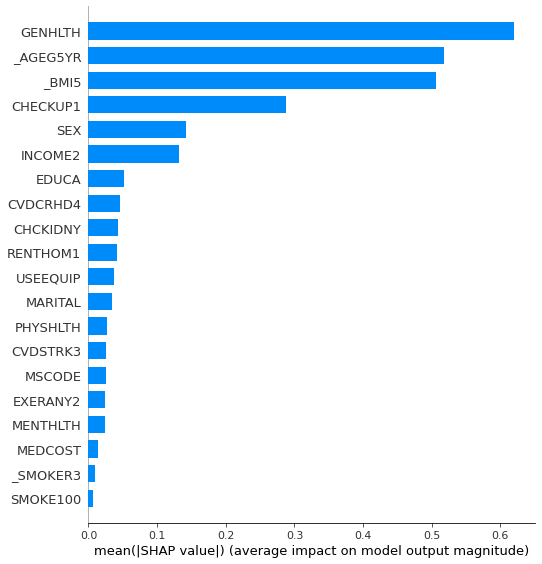


SHAP summary plots for 2013:


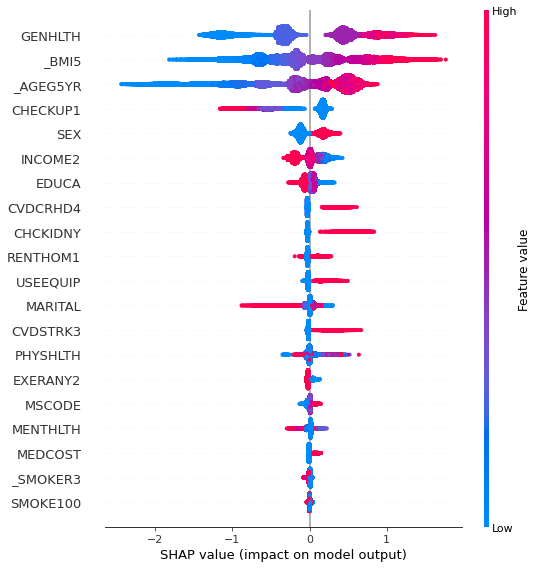

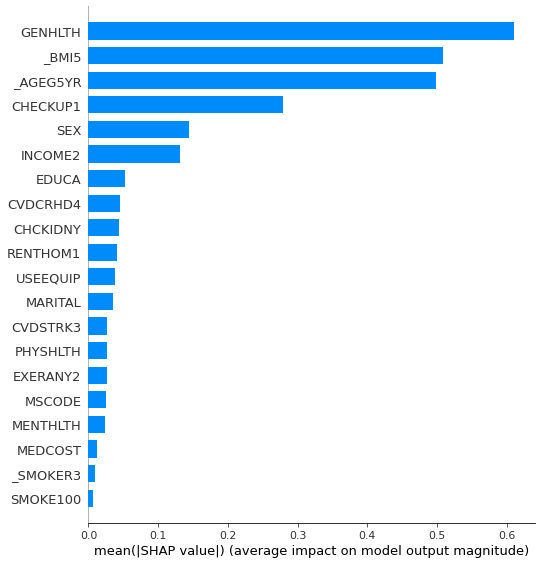


SHAP summary plots for 2014:


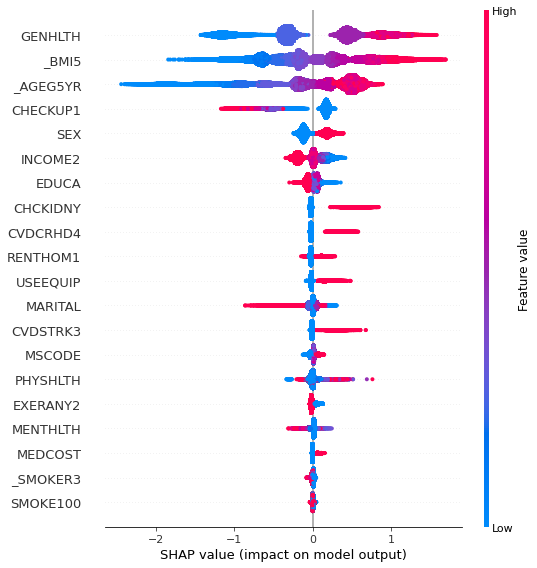

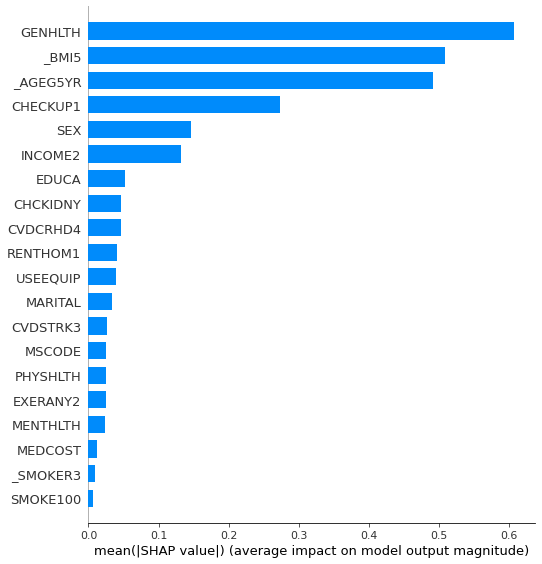

In [10]:
print("SHAP summary plots for 2011:")
shap.summary_plot(shap_values_2011[1], df_2011.drop(['Unnamed: 0','DIABETE3','_TOTINDA'], axis = 1))
shap.summary_plot(shap_values_2011[1], feature_names, plot_type='bar')
print()
print("SHAP summary plots for 2012:")
shap.summary_plot(shap_values_2012[1], df_2012.drop(['Unnamed: 0','DIABETE3','_TOTINDA'], axis = 1))
shap.summary_plot(shap_values_2012[1], feature_names, plot_type='bar')
print()
print("SHAP summary plots for 2013:")
shap.summary_plot(shap_values_2013[1], df_2013.drop(['Unnamed: 0','DIABETE3','_TOTINDA'], axis = 1))
shap.summary_plot(shap_values_2013[1], feature_names, plot_type='bar')
print()
print("SHAP summary plots for 2014:")
shap.summary_plot(shap_values_2014[1], df_2014.drop(['Unnamed: 0','DIABETE3','_TOTINDA'], axis = 1))
shap.summary_plot(shap_values_2014[1], feature_names, plot_type='bar')

We also performed SHAP on the cleaned datasets of other years. We found that top 6 features for all the four years were same as those for the cleaned 2015 dataset as shown in figure 15. The order of features was also same as that observed for 2015, except for $2^{nd}$ and $3^{rd}$ most important features being swapped for years 2011 and 2012.

The top six features are described below:



The SHAP summary plots show that high values of GENHLTH push the model prediction towards $\textit{diabetic}$ class. This suggests that respondents who consider their general health to be 'poor' or 'fair' are more likely to be diabetic than who answer 'excellent' or 'very good'. Similar to GENHLTH, higher values of features \_BMI5 and \_AGE5YR also push class prediction towards 'diabetic'. This is consistent with what we expect based on literature, that is older people or people having weight status of 'overweight' or 'obese' are more prone to diabetes. From a socioeconomics point of view, we observe that lower household income pushes the prediction to  `diabetic'. Furthermore, interestingly, the SHAP values suggest that males are more likely to be diabetic than females.